# MODELLING
## Logistic Regression with Tensorflow Core API
### Fraud Detection System Development using Deep Neural Network for Reported Transactional Data in DANA

#### Import Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

#### Read CSV File

In [2]:
df = pd.read_csv('user_data_clip99_minmax.csv', sep = ';')

In [3]:
df = df.rename(columns={"Unnamed: 0": "id"})
df = df.drop(columns = ['uid', 'id'])
df.head()

,is_scammer,trx_date,report_date,registereddate,birthday,is_verified,aqc_freq_prepaid_mobile,aqc_mean_prepaid_mobile_amount,aqc_freq_topup,aqc_freq_topup_within_7d,...,gender_Male,gender_None,job_position_KARYAWAN,job_position_LAINNYA,job_position_PEGAWAI_NS,job_position_PELAJAR,job_position_RUMAH_TANGGA,job_position_SPESIALIS,job_position_TIDAK_KERJA,job_position_WIRASWASTA
0,1,0.376934,0.005629,0.673512,0.909517,1,0.019455,0.456958,0.022750,0.007009,...,0,0,0,0,0,1,0,0,0,0
1,0,0.552039,0.632270,0.784524,0.948204,1,0.000000,0.000000,0.038576,0.074766,...,1,0,0,0,0,1,0,0,0,0
2,0,0.772855,0.696998,0.783631,0.766422,1,0.077821,0.324991,0.683482,0.271028,...,1,0,0,0,0,0,0,0,0,1
3,0,0.535865,0.550657,0.565476,0.974102,1,0.042802,0.200904,0.092977,0.042056,...,0,0,0,0,0,1,0,0,0,0
4,0,0.786920,0.715760,0.999702,0.688586,1,0.000000,0.000000,0.031652,0.056075,...,1,0,0,0,0,0,0,0,0,1


#### Preparing Train and Validation Dataset

In [4]:
# Split Train and Validation Dataset
#from sklearn.model_selection import train_test_split
SPLIT_SIZE = 0.7368421

train_len = int(len(df) * SPLIT_SIZE)

shuffled_files = df.sample(frac = 1, random_state = 1)

test_set = shuffled_files[train_len:]
train_set = shuffled_files[:train_len]

y_train = train_set['is_scammer']
x_train = train_set.drop(columns=['is_scammer'])
y_test = test_set['is_scammer']
x_test = test_set.drop(columns=['is_scammer'])

In [5]:
y_train.value_counts()

is_scammer
0    15192
1    14809
Name: count, dtype: int64

In [6]:
y_test.value_counts()

is_scammer
0    5475
1    5241
Name: count, dtype: int64

In [7]:
# Convert to tensors
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[1])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

#### Modelling

In [8]:
def log_loss(y_pred, y):
    # Compute the log loss function
    ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(ce)

In [9]:
class LogisticRegression(tf.Module):
    
    def __init__(self):
        self.built = False
        
    def __call__(self, x, train=True):
        # Initialize the model parameters on the first call
        if not self.built:
            # Randomly generate the weights and the bias term
            rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
            rand_b = tf.random.uniform(shape=[], seed=22)
            self.w = tf.Variable(rand_w)
            self.b = tf.Variable(rand_b)
            self.built = True
        # Compute the model output
        z = tf.add(tf.matmul(x, self.w), self.b)
        z = tf.squeeze(z, axis=1)
        if train:
            return z
        return tf.sigmoid(z)

In [10]:
log_reg = LogisticRegression()

In [11]:
y_pred = log_reg(x_train[:5], train=False)
y_pred.numpy()

array([0.9977224 , 0.9939011 , 0.995665  , 0.99588495, 0.99782157],
      dtype=float32)

In [12]:
def predict_class(y_pred, thresh=0.5):
    # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
    return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
    # Return the proportion of matches between `y_pred` and `y`
    y_pred = tf.math.sigmoid(y_pred)
    y_pred_class = predict_class(y_pred)
    check_equal = tf.cast(y_pred_class == y,tf.float32)
    acc_val = tf.reduce_mean(check_equal)
    return acc_val

In [13]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

In [14]:
# Set training parameters
epochs = 200
learning_rate = 0.001
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_test, batch_accs_test = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred_batch = log_reg(x_batch)
            batch_loss = log_loss(y_pred_batch, y_batch)
        batch_acc = accuracy(y_pred_batch, y_batch)
        # Update the parameters with respect to the gradient calculations
        grads = tape.gradient(batch_loss, log_reg.variables)
        for g,v in zip(grads, log_reg.variables):
            v.assign_sub(learning_rate * g)
        # Keep track of batch-level training performance
        batch_losses_train.append(batch_loss)
        batch_accs_train.append(batch_acc)

    # Iterate over the testing data
    for x_batch, y_batch in test_dataset:
        y_pred_batch = log_reg(x_batch)
        batch_loss = log_loss(y_pred_batch, y_batch)
        batch_acc = accuracy(y_pred_batch, y_batch)
        # Keep track of batch-level testing performance
        batch_losses_test.append(batch_loss)
        batch_accs_test.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 3.144
Epoch: 20, Training log loss: 0.353
Epoch: 40, Training log loss: 0.209
Epoch: 60, Training log loss: 0.145
Epoch: 80, Training log loss: 0.110
Epoch: 100, Training log loss: 0.088
Epoch: 120, Training log loss: 0.074
Epoch: 140, Training log loss: 0.063
Epoch: 160, Training log loss: 0.055
Epoch: 180, Training log loss: 0.049


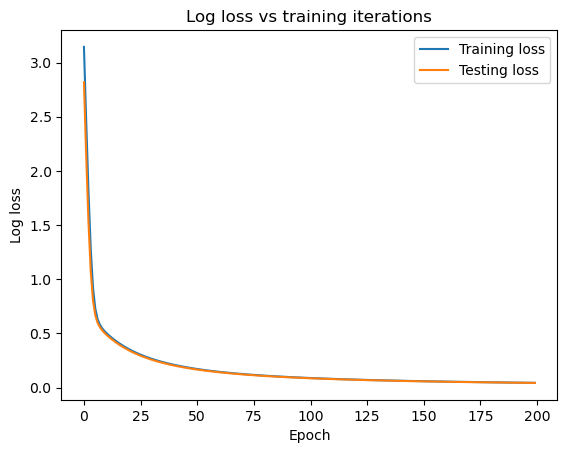

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

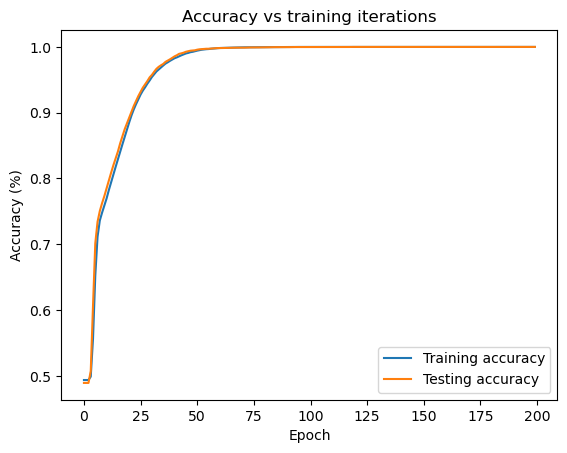

In [16]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [17]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.044
Final testing log Loss: 0.043


In [18]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 1.000
Final testing accuracy: 1.000


In [19]:
import sklearn.metrics as metrics

def show_confusion_matrix(y, y_classes, typ):
    # Compute the confusion matrix and normalize it
    plt.figure(figsize=(10,10))
    confusion = metrics.confusion_matrix(y.numpy(), y_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1)
    axis_labels = range(2)
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True)
    plt.title(f"Confusion matrix: {typ}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train, train=False), log_reg(x_test, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

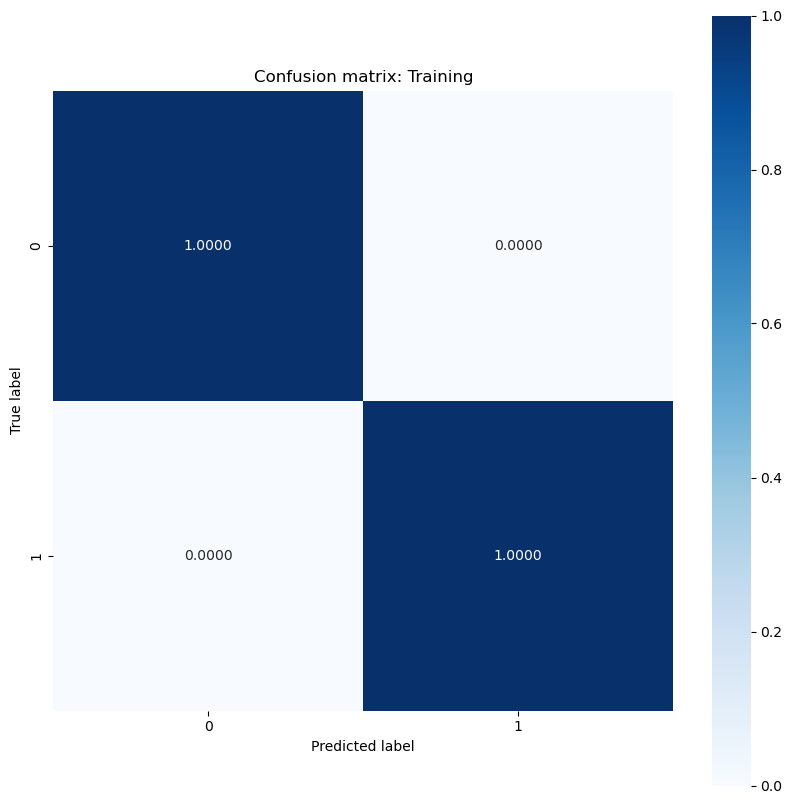

In [20]:
from sklearn import metrics
import seaborn as sns
show_confusion_matrix(y_train, train_classes, 'Training')

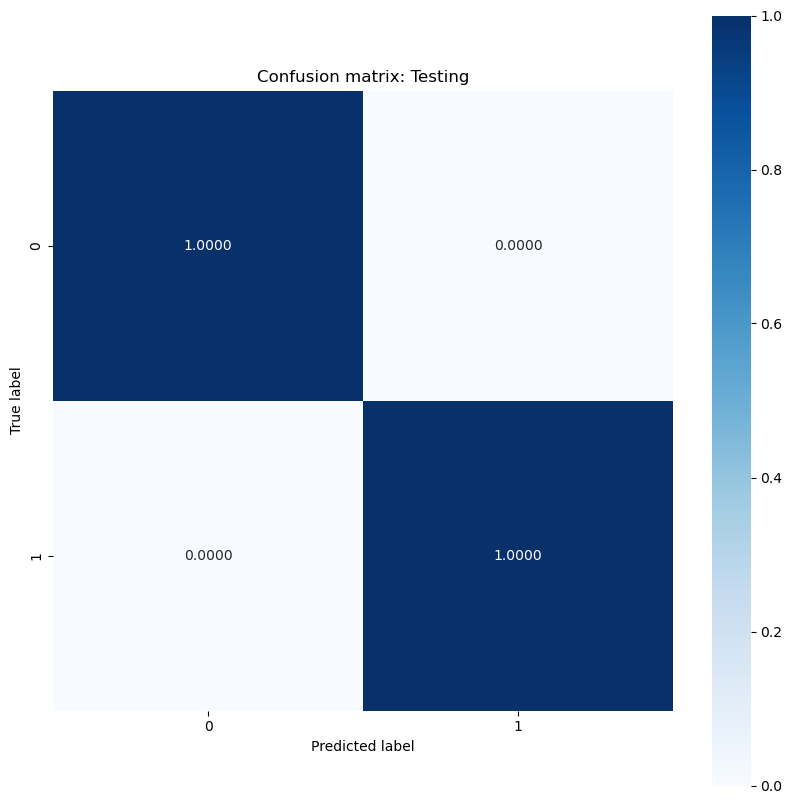

In [21]:
show_confusion_matrix(y_test, test_classes, 'Testing')

Source:
https://www.tensorflow.org/guide/core/logistic_regression_core

In [22]:
class ExportModule(tf.Module):
  def __init__(self, model, class_pred):
    # Initialize pre- and post-processing functions
    self.model = model
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
  def __call__(self, x):
    # Run the `ExportModule` for new data points
    y = self.model(x, train=False)
    y = self.class_pred(y)
    return y

In [23]:
log_reg_export = ExportModule(model=log_reg,
                              class_pred=predict_class)

In [25]:
import tempfile
import os
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'log_reg_export')


In [ ]:
tf.saved_model.save(log_reg_export, save_path, save_format='h5')

In [27]:
log_reg.save("log_reg_export.h5")

AttributeError: 'LogisticRegression' object has no attribute 'save'

#### Convert TF pb into h5

In [28]:
# Loading the Tensorflow Saved Model (PB)
model_toh5 = tf.keras.models.load_model("log_reg_export")

In [ ]:
model_path = "https://tfhub.dev/google/universal-sentence-encoder/4"

def save_model(model_path):
    model = tf.keras.Sequential()
    hub_layer = hub.KerasLayer(model_path, 
                               input_shape=[], 
                               dtype=tf.string, trainable=False)
    model.add(hub_layer)
    model.save('saved/')

save_model(model_path)
model = tf.keras.models.load_model('/content/saved')
model.summary() # OK 
model.get_weights() # OK

In [37]:
!pip install --upgrade tensorflow_hub

     ------------------------------------ 100.6/100.6 kB 386.0 kB/s eta 0:00:00


In [38]:
import os
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image

pb_model_dir = "log_reg_export"
h5_model = "log_reg_export.h5"

def save_model(model_path):
    model2 = tf.keras.Sequential()
    hub_layer = hub.KerasLayer(model_path, 
                               input_shape=[], 
                               dtype=tf.string, trainable=False)
    model2.add(hub_layer)
    model2.save('saved/')

save_model(pb_model_dir)
model2 = tf.keras.models.load_model('/content/saved')
model2.summary() # OK 
model2.get_weights() # OK

# Loading the Tensorflow Saved Model (PB)
model2 = tf.keras.models.load_model(pb_model_dir)
# print(model2.summary())

# Saving the Model in H5 Format
tf.keras.models.save_model(model2, h5_model)

# Loading the H5 Saved Model
loaded_model_from_h5 = tf.keras.models.load_model(h5_model)
print(loaded_model_from_h5.summary())

ValueError: Exception encountered when calling layer "keras_layer" (type KerasLayer).

in user code:

    File "D:\Application\Anaconda\lib\site-packages\tensorflow_hub\keras_layer.py", line 234, in call  *
        result = f()

    ValueError: Python inputs incompatible with input_signature:
      inputs: (
        Tensor("Placeholder:0", shape=(None,), dtype=string))
      input_signature: (
        TensorSpec(shape=(None, None), dtype=tf.float32, name=None)).


Call arguments received by layer "keras_layer" (type KerasLayer):
  • inputs=tf.Tensor(shape=(None,), dtype=string)
  • training=None